# Unit 4.3: Implementing a Multilayer Perceptron (XOR)

## Part 2 of 2

## 1) Installing Libraries

In [ ]:
# !conda install numpy pandas matplotlib scikit-learn --yes

In [ ]:
# !pip install torch torchvision torchaudio

In [ ]:
# !conda install watermark

## 2) Loading the Dataset

In [ ]:
import pandas as pd
import numpy as np


# df = pd.read_csv("xor.csv")
# df

url = 'https://raw.githubusercontent.com/fhsiddiqui/dataset/refs/heads/main/xor.csv'
df = pd.read_csv(url)
df

print(df)

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [ ]:
# !pip install scikit-learn

In [2]:
X = df[["x1", "x2"]].values
y = df["class label"].values

df["class label"].value_counts()

,count
class label,
0,376
1,374


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

In [4]:
print("Training size:", X_train.shape)
print("Validation size :", X_val.shape)
print("Test size: ", X_test.shape)

Training size: (573, 2)
Validation size : (64, 2)
Test size:  (113, 2)


In [5]:
import numpy as np

print("Training labels:", np.bincount(y_train))
print("Validation labels:", np.bincount(y_val))
print("Test labels:", np.bincount(y_test))

Training labels: [287 286]
Validation labels: [32 32]
Test labels: [57 56]


## 3) Visualizing the dataset

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

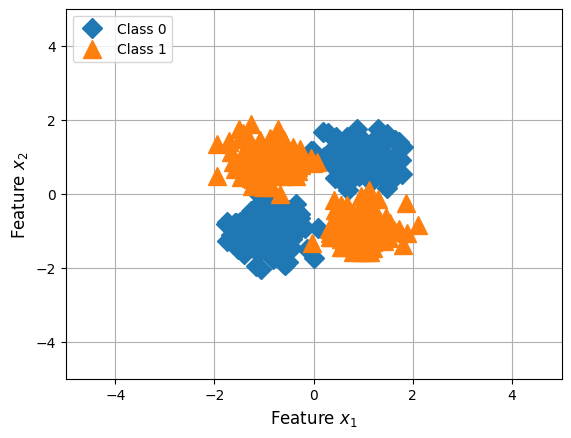

In [7]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

## 4) Implementing the model

In [8]:
import torch


class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(

            # 1st hidden layer
            torch.nn.Linear(num_features, 25),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(15, num_classes),
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

## 5) Defining a DataLoader

In [9]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.labels.shape[0]


train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
)

## 6) The training loop

In [ ]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():  # basically the same as torch.no_grad
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

**Training loop**

- Similar to Unit 3.6 -- Logistic Regression in PyTorch
- Differences are
  - `PytorchMLP` instead of `LogisticRegression` model
  - `F.cross_entropy` instead of `F.binary_cross_entropy`
  
<br>

- Note that F.cross_entropy takes `logits` as inputs, not probabilities
  - it does the one-hot encoding and softmax internally

In [ ]:
import torch.nn.functional as F


torch.manual_seed(1)
model = PyTorchMLP(num_features=2, num_classes=2)
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)  # Loss function

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

Epoch: 001/010 | Batch 000/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 001/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 002/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 003/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 004/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 005/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 006/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 007/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 008/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 009/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 010/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 011/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 012/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 013/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 014/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 015/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 016/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 017/018 | Train/Val Loss: 0.65
Train Acc 68.41% | Val Acc 6

## 7) Evaluating the results

In [13]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 98.25%
Val Acc 100.00%
Test Acc 99.12%


## 8) Optional: visualizing the decision boundary

In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    # edgecolor='black',
                    marker=markers[idx],
                    label=cl)

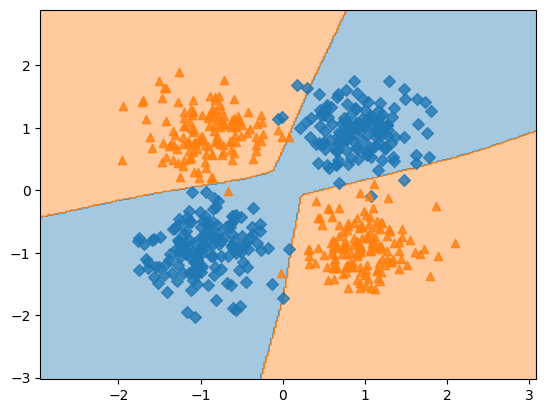

In [15]:
plot_decision_regions(X_train, y_train, classifier=model)